In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPool2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
%matplotlib inline

C:\Users\Personal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Personal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Personal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Personal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

In [2]:
train_path = r'dogs-vs-cats\train\train'
catagories = []
imgs = os.listdir(train_path)
for filename in imgs: 
    catagory = filename.split('.')[0]
    if(catagory == 'cat'):
        catagories.append(0)
    else:
        catagories.append(1)
data = pd.DataFrame({'filenames':imgs,
                    'catagories':catagories})


In [3]:
data.head()

,filenames,catagories
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [4]:
data.tail()

,filenames,catagories
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


(375, 499)

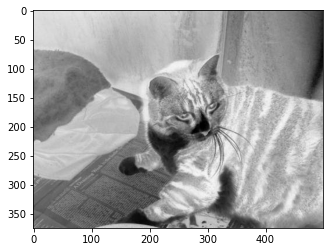

In [5]:
sample = os.path.join(train_path,imgs[2000])
img = cv2.imread(sample,cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap = 'binary')
img.shape

(342, 301)

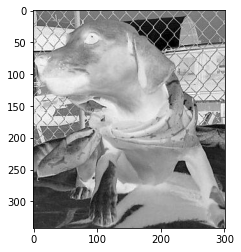

In [6]:
sample = os.path.join(train_path,imgs[20000])
img = cv2.imread(sample,cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap = 'binary')
img.shape

In [7]:
data['catagories'].replace([0,1],['cat','dog'],inplace = True)

In [8]:
data.head()

,filenames,catagories
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [9]:
data.tail()

,filenames,catagories
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


In [10]:
from sklearn.model_selection import train_test_split
train_data,validate_data = train_test_split(data,test_size = 0.25,random_state = 55)

In [11]:
train_data

,filenames,catagories
7359,cat.5371.jpg,cat
12476,cat.9978.jpg,cat
9229,cat.7054.jpg,cat
6532,cat.4627.jpg,cat
15443,dog.1397.jpg,dog
...,...,...
15159,dog.12390.jpg,dog
10213,cat.7940.jpg,cat
16253,dog.2125.jpg,dog
17352,dog.3114.jpg,dog


In [12]:
validate_data

,filenames,catagories
22016,dog.7312.jpg,dog
19882,dog.5392.jpg,dog
20361,dog.5823.jpg,dog
12608,dog.10094.jpg,dog
24652,dog.9686.jpg,dog
...,...,...
2622,cat.12357.jpg,cat
20755,dog.6178.jpg,dog
18708,dog.4335.jpg,dog
1283,cat.11151.jpg,cat


In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_dataframe(
    train_data, 
    train_path, 
    x_col='filenames',
    y_col='catagories',
    target_size=(128,128),
    color_mode = 'grayscale',
    class_mode='categorical',
    batch_size=15
)

Found 18750 validated image filenames belonging to 2 classes.


In [14]:
validate_datagen = ImageDataGenerator(rescale = 1./255)
validate_gen = validate_datagen.flow_from_dataframe(
    validate_data,
    train_path,
    x_col='filenames',
    y_col='catagories',
    target_size=(128,128),
    color_mode = 'grayscale',
    class_mode='categorical',
    batch_size=15    
)

Found 6250 validated image filenames belonging to 2 classes.


In [15]:
class myCallBacks(tf.keras.callbacks.Callback):
    def end_of_epoch(self,epoch,logs = {}):
        if(logs.get('accuracy') >= 0.95):
            print('\n accuracy achived above 95% \n')
            self.model.stop_training = True

In [16]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation = tf.nn.relu,input_shape = (128,128,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3),activation = tf.nn.relu))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3),activation = tf.nn.relu))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(512,activation = tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(2,activation = tf.nn.softmax))

es = EarlyStopping(patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              patience=2,
                              factor = 0.3,
                             min_lr=0.0001)

model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])
print(model.summary())
history = model.fit_generator(train_gen,epochs = 20,validation_data = validate_gen,callbacks = [es,reduce_lr,myCallBacks()])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)      

In [17]:
test_path = r'22535_28903_bundle_archive\dataset\test_set'
#test_data = np.load('testing_data.npy',allow_pickle = True)
test_data = []
catagories = ['cats','dogs']
def t_data():
    for c in catagories:
        num = catagories.index(c)
        path = os.path.join(test_path,c)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_arr = cv2.resize(img_arr,(128,128))
                test_data.append([new_arr,num])
            except Exception as e:
                pass
t_data()



In [18]:
import random
random.shuffle(test_data)

In [19]:
x = []
y = []
for features,labels in test_data:
    x.append(features)
    y.append(labels)

In [20]:
x = np.array(x)
y = np.array(y)

In [21]:
x.shape

(2000, 128, 128)

In [22]:
x = x/255.0

In [23]:
x = x.reshape(2000,128,128,1)
#y_test = y_test.reshape(2000,50,50,1)

In [24]:
x[0].shape

(128, 128, 1)

In [25]:
y = keras.utils.to_categorical(y,num_classes=2)

In [26]:
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [27]:
model.evaluate(x,y)

2000/2000 [==============================] - 8s 4ms/step


[0.13680466390773655, 0.9624999761581421]

In [28]:
history.history

{'val_loss': [0.5256226658821106,
  0.623407244682312,
  0.7672408819198608,
  0.41229668259620667,
  0.4932890832424164,
  0.0888887345790863,
  0.3428899943828583,
  0.06206900626420975,
  0.03922896832227707,
  0.4772169589996338,
  1.0961488485336304,
  0.18472634255886078,
  0.26375144720077515,
  0.8961982727050781,
  0.3281398415565491,
  0.6893845796585083,
  0.014896106906235218,
  1.3429863452911377,
  0.206930473446846,
  0.8105289340019226],
 'val_accuracy': [0.7452800273895264,
  0.608959972858429,
  0.7068799734115601,
  0.8505600094795227,
  0.855679988861084,
  0.858240008354187,
  0.869920015335083,
  0.8551999926567078,
  0.8675199747085571,
  0.8729599714279175,
  0.865119993686676,
  0.8686400055885315,
  0.8659200072288513,
  0.8704000115394592,
  0.860319972038269,
  0.8702399730682373,
  0.8684800267219543,
  0.8615999817848206,
  0.8588799834251404,
  0.8657600283622742],
 'loss': [0.6570999114155769,
  0.4568824459671974,
  0.39427858295440676,
  0.288731764605

In [29]:
%matplotlib

Using matplotlib backend: Qt5Agg


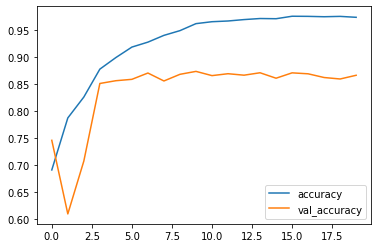

In [30]:
plt.plot(history.epoch,history.history['accuracy'],label = 'accuracy')
plt.plot(history.epoch,history.history['val_accuracy'],label = 'val_accuracy')
plt.legend()

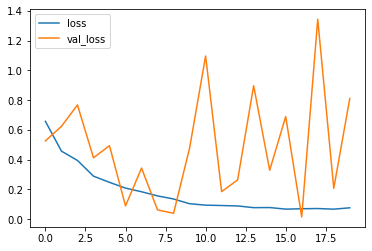

In [31]:
plt.plot(history.epoch,history.history['loss'],label = 'loss')
plt.plot(history.epoch,history.history['val_loss'],label = 'val_loss')

plt.legend()

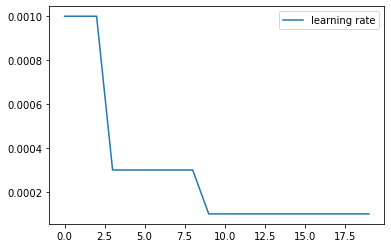

In [32]:
plt.plot(history.epoch,history.history['lr'],label = 'learning rate')

plt.legend()

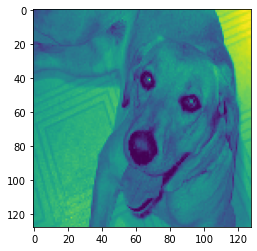

In [70]:
unseen_test_path = r'dogs-vs-cats\test1\test1'
img =  random.choice(os.listdir(unseen_test_path))
path = os.path.join(unseen_test_path,img)
img_arr = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
new_arr = cv2.resize(img_arr,(128,128))
plt.imshow(new_arr)
new_arr = new_arr.reshape(-1,128,128,1)

In [71]:
new_arr.shape

(1, 128, 128, 1)

In [72]:
for i in model.predict([new_arr]):
    if(i[0] == 1):
        print('Cat')
    else:
        print('Dog')

Dog
